# Baseline Test

In [2]:
import pandas as pd
import numpy as np
#NLTK
import string
import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
#Sklearn
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report 
#Matplotlib
import matplotlib
from matplotlib import pyplot as plt
import re
%matplotlib inline

/home/ayu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df_listings=pd.read_csv('listings/listings.csv')

/home/ayu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (43,61,62,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_reviews=pd.read_csv('reviews/reviews.csv')

In [5]:
df_reviews.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2515,198,2008-10-13,2603,Jenny,Stephanie was a wonderful host! Her apartment ...
1,2515,859,2009-03-08,8455,Roland,Such a wonderful place and very close to the m...
2,2515,1083,2009-03-25,9759,Cem,I just got back from a trip to NYC during whic...
3,2515,1107,2009-03-27,9193,Holly,Stephanie's offered all the most important thi...
4,2515,2175,2009-05-09,7048,Alessandra,"Stephanie was really nice, ftiendly and helpfu..."


In [6]:
#fill nans with none in comments
df_reviews.comments.fillna('none',inplace=True)

#### Check how many rows have the word super host in it

In [7]:
df_reviews[df_reviews.comments.str.contains('super host')==True].shape

(1217, 6)

#### Replace all superhost strings with a blank space in each "review"

In [8]:
df_reviews.comments.replace("superhost","",inplace=True)

In [9]:
#join all reviews together by listing_id (this will allow me run tf-idf on all my reviews together and look for topics/features)
df_reviews=df_reviews.groupby(['listing_id'])['comments'].apply(','.join).reset_index()

In [10]:
df_reviews.head(5)

,listing_id,comments
0,2515,Stephanie was a wonderful host! Her apartment ...
1,2539,"Great host ,Nice room for the price. Great nei..."
2,2595,Notre séjour de trois nuits.\r\nNous avons app...
3,3330,I haven't met Julia but her place is very nice...
4,3831,"lisa is a wonderful, kind and thoughtful host...."


In [11]:
df_combined=pd.merge(df_listings, df_reviews, left_on='id', right_on='listing_id', how='left')

In [12]:
df_combined.host_is_superhost.isnull().sum()

106

In [13]:
df_combined['host_is_superhost'].fillna('f', inplace = True)

In [14]:
df_combined.replace({'host_is_superhost': {'t': True, 'f': False}},inplace=True)

In [15]:
df_combined.comments.isnull().sum()

10936

In [16]:
#update df_combined to only include reviews 
df_combined=df_combined[df_combined.comments.isnull()==False]

In [17]:
df_combined.shape

(37916, 98)

In [18]:
df_combined[df_combined.host_is_superhost==True].shape

(6322, 98)

In [19]:
6322/37916

0.1667369975735837

In [20]:
new_df=df_combined

In [21]:
super_pop = int(new_df.shape[0]*.16673)
super_pop

6321

In [22]:
reg_pop = int(new_df.shape[0]*(1 - .16673))
reg_pop

31594

In [23]:
sample_size = 37916
super_perc = .16673


reg_perc = 1 - super_perc

# Sample sizes
super_sample_size = int(sample_size * super_perc)
reg_sample_size = int(sample_size * reg_perc)

supers = new_df[new_df.host_is_superhost == 1]
regs = new_df[new_df.host_is_superhost == 0]

super_samples = supers.sample(super_sample_size)
reg_samples = regs.sample(reg_sample_size)

df_sample = super_samples.append(reg_samples)

In [24]:
df_sample.host_is_superhost.value_counts()

False    31594
True      6321
Name: host_is_superhost, dtype: int64

In [25]:
print(super_samples.shape)
super_samples.host_is_superhost.unique()

(6321, 98)


array([ True])

In [26]:
print(reg_samples.shape)
reg_samples.host_is_superhost.unique()

(31594, 98)


array([False])

### NLP Scrubber

In [27]:
#punctuation remover
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [28]:
df_sample['comments'] = df_sample['comments'].apply(remove_punctuation)

In [29]:
# create an object of stemming function
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [30]:
df_sample['comments'] = df_sample['comments'].apply(stemming)

In [31]:
def plot_roc(y_test, X_test, model, model_name):
    try:
        AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % AUC)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic {}'.format(model_name))
        plt.legend(loc="lower right");
    except:
        None

In [34]:
def train_predict(classifier, X, y):
    #train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)
    #fit_classifier
    classifier.fit(X_train, y_train)
    y_predictions = classifier.predict(X_test)
    print("Accuracy")
    #train_test_accuracy
    print ("Train Accuracy : {}".format(accuracy_score(y_train, classifier.predict(X_train))))
    print ("Test Accuracy  : {}".format(accuracy_score(y_test, y_predictions)))
    print("")
    print("Confusion Matrix")
    #confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_predictions).ravel()
    print("True Negative: {}".format(tn))
    print("True Positive: {}".format(tp))
    print("False Negative: {}".format(fn))
    print("False Positive: {}".format(fp))
    print("")
    #classification_report
    print("Classification Report")
    print(classification_report(y_test, y_predictions, target_names=['Not_Superhost', 'Superhost']))
    #roc_curve
    print("")
    plot_roc(y_test, X_test, model=classifier, model_name="classifier")
    return None

## CountVectorizer only

### Naive Bayes Baseline

Accuracy
Train Accuracy : 0.886235757490505
Test Accuracy  : 0.7942820972676443

Confusion Matrix
True Negative: 6863
True Positive: 666
False Negative: 914
False Positive: 1036

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.88      0.87      0.88      7899
    Superhost       0.39      0.42      0.41      1580

  avg / total       0.80      0.79      0.80      9479




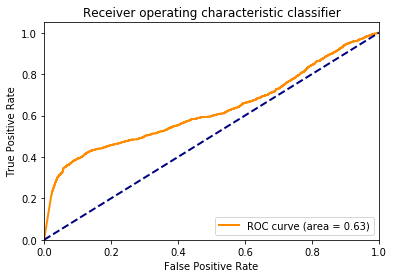

In [128]:
trial = Pipeline([
    ('vect', CountVectorizer(stop_words='english', lowercase=True)),
    ('clf', MultinomialNB())
])

train_predict(trial, df_sample['comments'], df_sample['host_is_superhost'])

### Logistic Regression Baseline

Accuracy
Train Accuracy : 0.958362638908426
Test Accuracy  : 0.866230615043781

Confusion Matrix
True Negative: 7506
True Positive: 705
False Negative: 875
False Positive: 393

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.90      0.95      0.92      7899
    Superhost       0.64      0.45      0.53      1580

  avg / total       0.85      0.87      0.86      9479




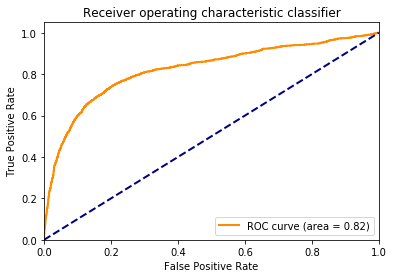

In [129]:
trial1 = Pipeline([
    ('vect', CountVectorizer(stop_words='english', lowercase=True)),
    ('clf', LogisticRegression())
])

train_predict(trial1, df_sample['comments'], df_sample['host_is_superhost'])

### Random Forest Classifier Baseline

Accuracy
Train Accuracy : 0.9799198199465466
Test Accuracy  : 0.8393290431480114

Confusion Matrix
True Negative: 7798
True Positive: 158
False Negative: 1422
False Positive: 101

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.85      0.99      0.91      7899
    Superhost       0.61      0.10      0.17      1580

  avg / total       0.81      0.84      0.79      9479




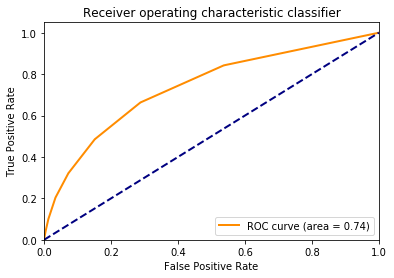

In [130]:
trial2 = Pipeline([
    ('vect', CountVectorizer(stop_words='english', lowercase=True)),
    ('clf', RandomForestClassifier())
])

train_predict(trial2, df_sample['comments'], df_sample['host_is_superhost'])

### Gradient Boosting Classifier Baseline

Accuracy
Train Accuracy : 0.8808904205936138
Test Accuracy  : 0.8661251186834055

Confusion Matrix
True Negative: 7660
True Positive: 550
False Negative: 1030
False Positive: 239

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.88      0.97      0.92      7899
    Superhost       0.70      0.35      0.46      1580

  avg / total       0.85      0.87      0.85      9479




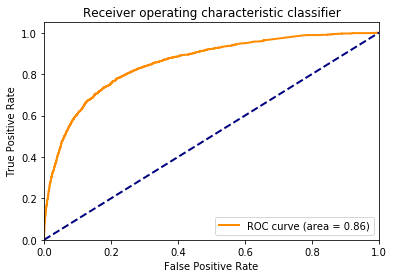

In [131]:
trial3 = Pipeline([
    ('vect', CountVectorizer(stop_words='english', lowercase=True)),
    ('clf', GradientBoostingClassifier())
])

train_predict(trial3, df_sample['comments'], df_sample['host_is_superhost'])

### LinearSVC Baseline

In [132]:
trial4 = Pipeline([
    ('vect', CountVectorizer(stop_words='english', lowercase=True)),
    ('clf', LinearSVC())
])

train_predict(trial4, df_sample['comments'], df_sample['host_is_superhost'])

Accuracy
Train Accuracy : 0.9977141651427768
Test Accuracy  : 0.8219221436860429

Confusion Matrix
True Negative: 7106
True Positive: 685
False Negative: 895
False Positive: 793

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.89      0.90      0.89      7899
    Superhost       0.46      0.43      0.45      1580

  avg / total       0.82      0.82      0.82      9479




## TfidfVectorizer only

### Naive Bayes Baseline

Accuracy
Train Accuracy : 0.8332747221831481
Test Accuracy  : 0.8333157506066041

Confusion Matrix
True Negative: 7899
True Positive: 0
False Negative: 1580
False Positive: 0

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.83      1.00      0.91      7899
    Superhost       0.00      0.00      0.00      1580

  avg / total       0.69      0.83      0.76      9479




/home/ayu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


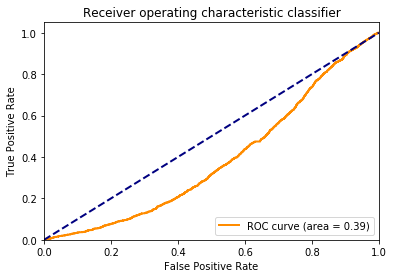

In [133]:
trial5 = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('clf', MultinomialNB())
])

train_predict(trial5, df_sample['comments'], df_sample['host_is_superhost'])

### Logistic Regression Baseline

Accuracy
Train Accuracy : 0.8687930791953862
Test Accuracy  : 0.8459753138516721

Confusion Matrix
True Negative: 7642
True Positive: 377
False Negative: 1203
False Positive: 257

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.86      0.97      0.91      7899
    Superhost       0.59      0.24      0.34      1580

  avg / total       0.82      0.85      0.82      9479




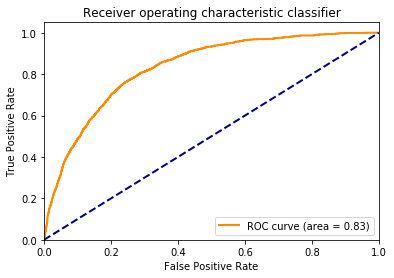

In [134]:
trial6 = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('clf', LogisticRegression())
])

train_predict(trial6, df_sample['comments'], df_sample['host_is_superhost'])

### Random Forest Classifier Baseline

Accuracy
Train Accuracy : 0.9804824869883246
Test Accuracy  : 0.8374301086612512

Confusion Matrix
True Negative: 7806
True Positive: 132
False Negative: 1448
False Positive: 93

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.84      0.99      0.91      7899
    Superhost       0.59      0.08      0.15      1580

  avg / total       0.80      0.84      0.78      9479




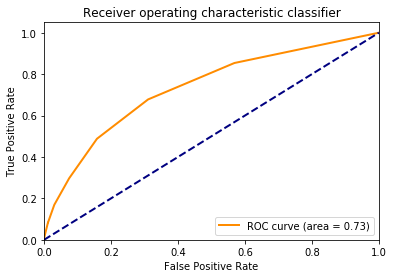

In [135]:
trial7 = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('clf', RandomForestClassifier())
])

train_predict(trial7, df_sample['comments'], df_sample['host_is_superhost'])

### Gradient Boosting Classifier Baseline

Accuracy
Train Accuracy : 0.8831410887607258
Test Accuracy  : 0.8691845131342969

Confusion Matrix
True Negative: 7670
True Positive: 569
False Negative: 1011
False Positive: 229

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.88      0.97      0.93      7899
    Superhost       0.71      0.36      0.48      1580

  avg / total       0.86      0.87      0.85      9479




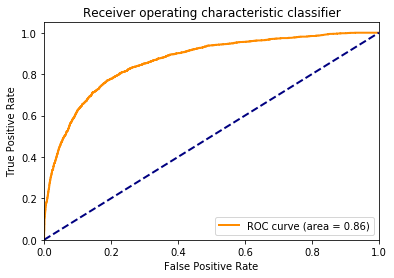

In [35]:
trial8 = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('clf', GradientBoostingClassifier())
])

train_predict(trial8, df_sample['comments'], df_sample['host_is_superhost'])

### LinearSVC Baseline

In [36]:
trial9 = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('clf', LinearSVC())
])

train_predict(trial9, df_sample['comments'], df_sample['host_is_superhost'])

Accuracy
Train Accuracy : 0.9589956393304262
Test Accuracy  : 0.8518831100327039

Confusion Matrix
True Negative: 7462
True Positive: 613
False Negative: 967
False Positive: 437

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.89      0.94      0.91      7899
    Superhost       0.58      0.39      0.47      1580

  avg / total       0.84      0.85      0.84      9479




#### Pick out the top 50 words from the model

In [137]:
trial7_featurenames=trial7.steps[0][1].get_feature_names()

In [136]:
trial7_importantfeats = trial7.steps[1][1].feature_importances_

In [138]:
indices = np.argsort(trial7_importantfeats)
feature_names = np.array(trial7_featurenames)[indices][-50:]

In [139]:
feature_names

array(['access', 'conveni', 'uber', 'like', 'minut', 'visit', 'apart',
       'problem', 'host', 'window', 'spacious', 'excel', 'seen', 'incred',
       'cerca', 'stay', 'comfi', 'noth', 'exact', 'alway', 'wonder',
       'comfort', 'hospit', 'great', 'veri', 'world', 'nearbi', 'place',
       'definit', 'zu', 'recommend', 'everywher', 'huge', 'late', 'just',
       'reserv', 'residenti', 'servic', 'autom', 'everyth', 'high',
       'locat', 'respons', 'luggag', 'complet', 'cool', 'eat', 'return',
       'train', 'beauti'], dtype='<U427')